# Read files

In [251]:
import awkward as ak
import numpy as np
import os, yaml
from coffea.nanoevents import NanoEventsFactory, BaseSchema

In [252]:
filepath = {
    year: {
        r'$Z^\mathrm{\prime}(1TeV)\to H(bb)\gamma$': f'input/{year}/mc_signal_Hbb_1000.root',
        r'$Z^\mathrm{\prime}(2TeV)\to H(bb)\gamma$': f'input/{year}/mc_signal_Hbb_2000.root',
        r'$Z^\mathrm{\prime}(3TeV)\to H(bb)\gamma$': f'input/{year}/mc_signal_Hbb_3000.root',
        'data': f'input/{year}/data_Hbb.root',
    } for year in ['2018']
}

SIG_COLOR = {
    r'$Z^\mathrm{\prime}(1TeV)\to H(bb)\gamma$': 'red',
    r'$Z^\mathrm{\prime}(2TeV)\to H(bb)\gamma$': 'red',
    r'$Z^\mathrm{\prime}(3TeV)\to H(bb)\gamma$': 'red',
}

events = {
    year: {
        k: NanoEventsFactory.from_root(file=filepath[year][k], treepath='Events', schemaclass=BaseSchema).events() for k in filepath[year]
    } for year in filepath
}

# Prepare plotting

In [253]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from cycler import cycler

use_helvet = True ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

def flow(hist: bh.Histogram, overflow: bool=True, underflow: bool=False):
    h, var = hist.view(flow=(overflow | underflow)).value, hist.view(flow=(overflow | underflow)).variance
    if overflow: # h, var also include underflow bins but in plots usually no underflow data
        # And we've filled None with -999, so we shouldn't show underflow data (mostly from filled None)
        h[-2] += h[-1]; var[-2] += var[-1]
    if underflow:
        h[1] += h[0]; var[1] += var[0]
    if overflow or underflow:
        h, var = h[1:-1], var[1:-1]
    return np.abs(h), var

def error_bar(h, var, mode='data'):
    from scipy.interpolate import CubicSpline
    
    h, var = np.array(h), np.array(var)
    if mode == 'data':
        number = h
    elif mode == 'mc':  # h = k*N, var = k^2*N, std = k*sqrt(N)
        number = np.nan_to_num(h**2/var, nan=0)
    else:
        raise ValueError("mode should be 'data' or 'mc'! ")
    center = range(11)
    up = np.array([1.84, 3.30, 4.64, 5.92, 7.16, 8.38, 9.58, 10.77, 11.95, 13.11, 14.27]) - center
    down = center - np.array([0, 0.17, 0.71, 1.37, 2.09, 2.84, 3.62, 4.42, 5.23, 6.06, 6.89])
    cs_up = CubicSpline(x=center, y=up)
    cs_down = CubicSpline(x=center, y=down)
    
    Garwood = (number>=0) & (number<=10)
    poison_error_bar = np.sqrt(number)
    up_error_bar = np.copy(poison_error_bar)
    down_error_bar = np.copy(poison_error_bar)
    up_error_bar[Garwood] = cs_up(number[Garwood])
    down_error_bar[Garwood] = cs_down(number[Garwood])
    
    if mode == 'mc':
        up_error_bar *= np.nan_to_num(var/h, nan=1)
        down_error_bar *= np.nan_to_num(var/h, nan=1)

    return np.array([down_error_bar, up_error_bar])

# Fitting

In [254]:
import scipy as sp
import scipy.stats as sps
from scipy.optimize import curve_fit
from scipy.stats import crystalball

## playground

In [170]:
# Internuclear separation in angstroms
distances = [2.875, 3.0, 3.125, 3.25, 3.375, 3.5, 3.75, 4.0, 4.5, 5.0, 6.0]
# Energy in Wavenumbers
energies = [0.35334378061169025, -2.7260131253801405, -4.102738968283382, -4.557042640311599, -4.537519193684069, -4.296388508321034, -3.6304745046204117, -3.0205368595885536, -2.1929538006724814, -1.7245616790238782, -1.2500789753171557]

distances, energies = np.array(distances), np.array(energies)

In [171]:
def Lennard_Jones(x, epsilon, sigma):
    y = 4*epsilon*((sigma/x)**12 - (sigma/x)**6)
    return y

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the foll

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial


[4.85719609 2.8927437 ]


findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the foll

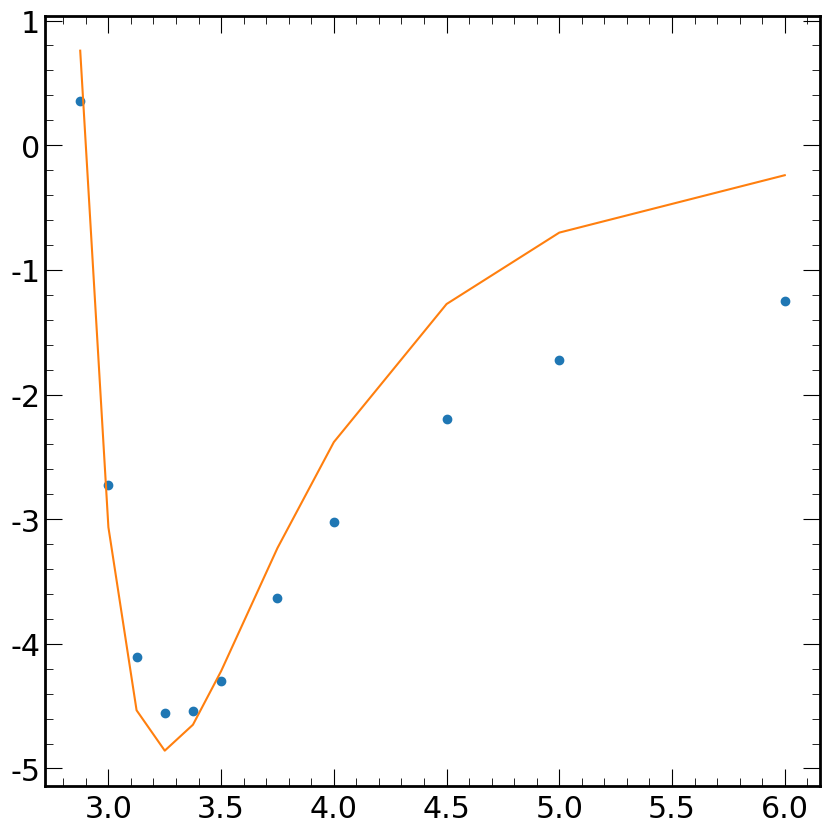

In [172]:
parameters, covariance = curve_fit(Lennard_Jones, xdata=distances, ydata=energies, bounds=([4, 3/2], [+np.inf, +np.inf]))
fit_result = Lennard_Jones(distances, *parameters)

plt.plot(distances, energies, 'o', label='data')
plt.plot(distances, fit_result, '-', label='fit')
print(parameters)

## work

### signal

In [328]:
def crystal_ball(x, x0, sigmaL, sigmaR, alphaL, alphaR, nL, nR):
    nL, nR = np.abs(nL), np.abs(nR)
    AL = (nL/np.abs(alphaL))**nL * np.exp(-np.abs(alphaL)**2 / 2)
    AR = (nR/np.abs(alphaR))**nR * np.exp(-np.abs(alphaR)**2 / 2)
    BL = nL/np.abs(alphaL) - np.abs(alphaL)
    BR = nR/np.abs(alphaR) - np.abs(alphaR)
    
    range1 = (x-x0)/sigmaL < -alphaL
    range2 = ((x-x0)/sigmaL >= -alphaL) & ((x-x0)/sigmaL < 0)
    range3 = ((x-x0)/sigmaR >= 0) & ((x-x0)/sigmaR <= alphaR)
    range4 = (x-x0)/sigmaR > alphaR
    
    y = np.copy(x)
    y[range1] = AL * (BL + np.abs(x[range1]-x0)/sigmaL)**(-nL)
    y[range2] = np.exp(- ((x[range2]-x0)/sigmaL)**2 / 2)
    y[range3] = np.exp(- ((x[range3]-x0)/sigmaR)**2 / 2)
    y[range4] = AR * (BR + np.abs(x[range4]-x0)/sigmaR)**(-nR)
    
    pdf = y/np.sum(y)
    return pdf


def signal_fit(arrays, weight, plot_name: str, x_name: str, cuts=None, year='2018', bins=None, x_min: float=0, x_max: float=2000, bin_width=None, function=None, parameters=None):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    if cuts:
        arrays = {k: v[cuts[k]] for k, v in arrays.items()}
    if bins is None:
        bins = (x_max - x_min)//bin_width
    if bin_width is None:
        bin_width = (x_max - x_min)/bins


    ## canvas initializing
    # f, ax = plt.subplots()
    f = plt.figure(figsize=(9, 9))
    gs = mpl.gridspec.GridSpec(3, 1, height_ratios=[5, 1, 1], hspace=0.08)
    ax, ax1, ax2 = f.add_subplot(gs[0]), f.add_subplot(gs[1]), f.add_subplot(gs[2])
    ax.grid(); ax1.grid(); ax2.grid()
    hep.cms.label(data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')


    ## analyze
    individual = {'h': {}, 'var': {}}
    
    x_axis = bh.axis.Regular(bins, x_min, x_max)
    hist = bh.Histogram(x_axis, storage=bh.storage.Weight())
    x_data = x_axis.centers
    
    for (k,v) in arrays.items():
        values = ak.fill_none(v, -999)
        
        if k!='data' and weight is not None:
            hist.fill(values, weight=weight[k]*len(weight[k])/np.sum(weight[k]))
        else:
            hist.fill(values)
        h, var = flow(hist=hist, overflow=False, underflow=False)

        individual['h'][k] = h
        individual['var'][k] = var


    ## plot
    ax1.plot([x_min,x_max], [1,1], color='black', linestyle='dashed')
    ax2.plot([x_min,x_max], [0,0], color='black', linestyle='dashed')
    # or you can specify color='blue' in the above function to cover colorlist (you could comment out colorlist too)
    for (k, h) in individual['h'].items():
        err = error_bar(h, individual['var'][k], mode='mc')
        hep.histplot(h, bins=x_axis.edges, yerr=err, label=k, histtype='errorbar', stack=False, ax=ax, color='black')
        
        fit = function(x_data, **parameters) * np.sum(h)
        # chi2 = sps.chisquare(f_obs=h, f_exp=fit, ddof=7).statistic
        ratio = h/fit; ratio[h==0] = 0
        ratio_err = np.min(err, axis=0)/fit; ratio_err[h==0] = 0
        flag = np.where(h > fit, np.zeros_like(h, dtype=np.int32), np.ones_like(h, dtype=np.int32))
        pull = ((h-fit)/err[flag, np.arange(err.shape[1])]); pull[h==0] = 0
        chi2 = np.sum(pull**2)

        ax.plot(x_data, fit, label='fit', linestyle='--', color=SIG_COLOR[k], linewidth=3)
        hep.histplot(ratio, yerr=ratio_err, bins=x_axis.edges, label=k, histtype='errorbar', stack=False, ax=ax1, color=SIG_COLOR[k])
        hep.histplot(pull, bins=x_axis.edges, label=k, histtype='fill', stack=False, ax=ax2, color=SIG_COLOR[k])


    ## axises
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0, 1.2*ax.get_ylim()[1])
    ax.set_xticklabels([])

    # ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    ax.set_ylabel('A.U.', fontsize=20, ha='right', y=1)

    # ratio panel
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(0.1, 1.9)
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax1.tick_params(axis='x', which='major', labelsize=0)
    ax1.set_ylabel(r'$\frac{MC}{Fit}$', fontsize=20, ha='center', y=0.5)

    ax2.set_xlim(x_min, x_max)
    max_ylim = np.max(np.abs(ax2.get_ylim()))
    ax2.set_ylim(-1.1*max_ylim, +1.1*max_ylim)
    #ax2.set_yticks(ticks=range(-4, 5, 2))
    ax2.tick_params(axis='both', which='major', labelsize=16)
    ax2.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax2.set_ylabel(r'$\frac{MC - Fit}{MC\ unc.}$', fontsize=20, ha='center', y=0.5)


    ## title, text and legend
    # plt.title('ROC Curve of HWW4q vs. QCD', fontsize=24,color="black")
    ax.legend(loc="best", ncol=1, frameon=False, fontsize=18)
    ax.text(ax.get_xlim()[1]-30, ax.get_ylim()[1]*0.6, r"$\frac{\chi^2}{NDF}=\frac{%.2f}{%d - %d}=%.2f$"%(chi2, bins, 7, chi2/(bins-7)), fontsize=22, color="black", ha='right')

    ## finalizing
    if not os.path.exists(f'../plots/fit/{year}'):
        os.makedirs(f'../plots/fit/{year}')
    plt.savefig(f"../plots/fit/{year}/{plot_name}.pdf", bbox_inches='tight')
    plt.show()

/tmp/ipykernel_34177/2889715501.py:33: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_34177/2889715501.py:50: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_34177/2889715501.py:51: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: G

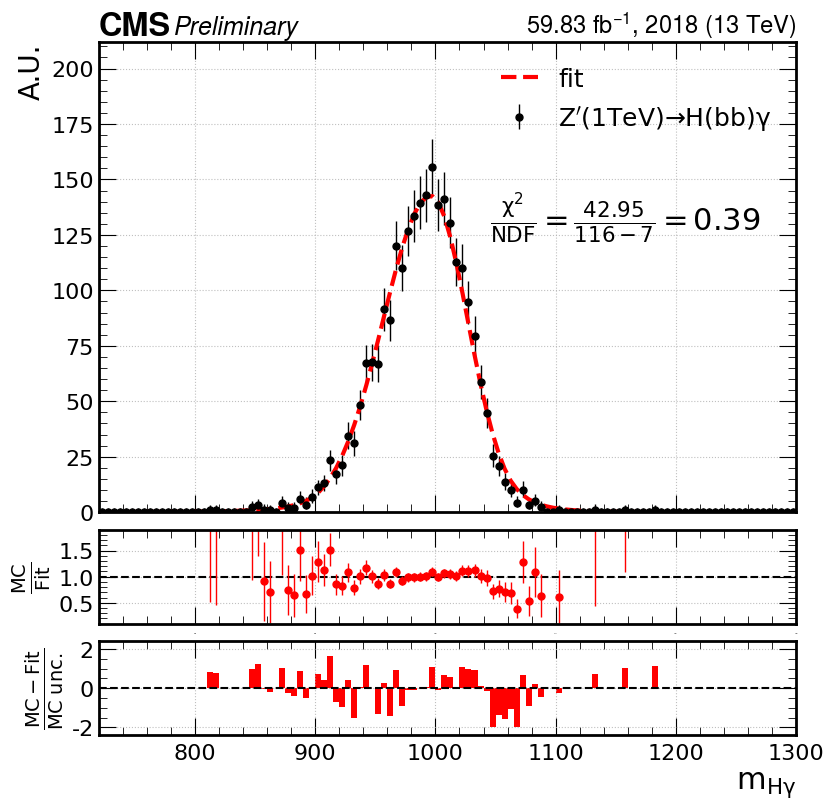

/tmp/ipykernel_34177/2889715501.py:33: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_34177/2889715501.py:50: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_34177/2889715501.py:51: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: G

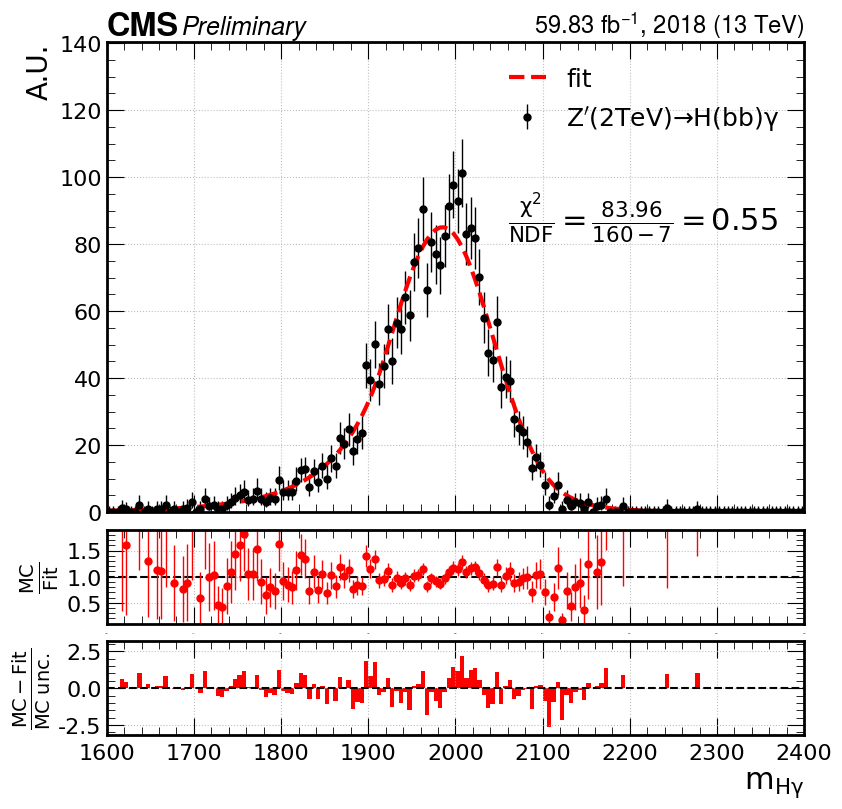

/tmp/ipykernel_34177/2889715501.py:33: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_34177/2889715501.py:50: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_34177/2889715501.py:51: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: G

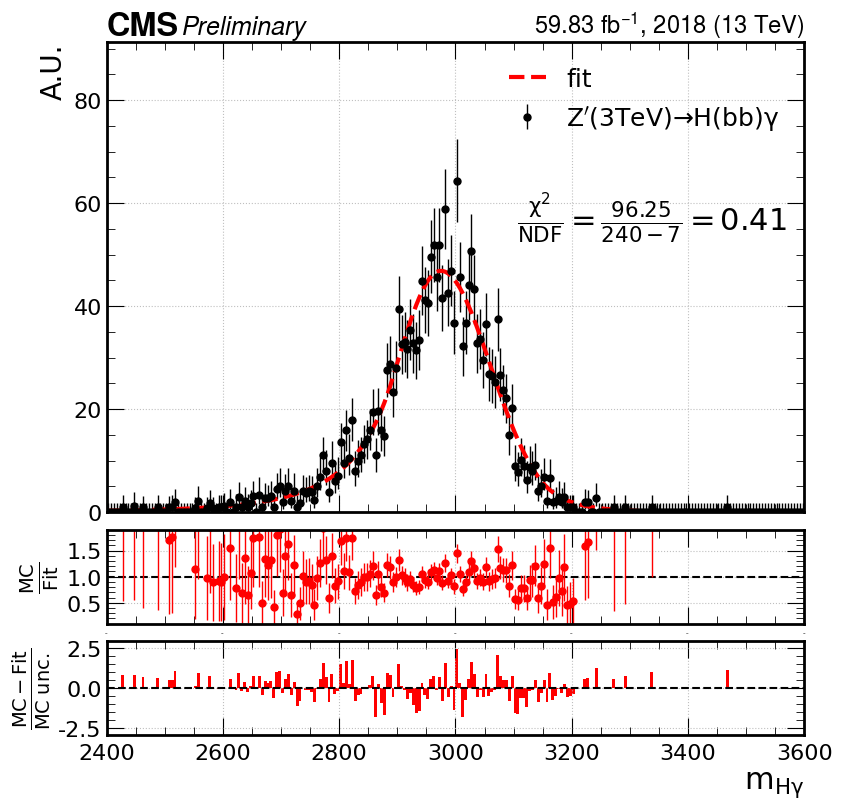

In [335]:
y = '2018'
SR_cut="""((events[y][k].mass_Higgs > 110) & (events[y][k].mass_Higgs < 140) & (events[y][k].tagger_Hbb > 0.5) &  (events[y][k].tagger_Hbb <0.8))"""


with open('output/2018/fit_info_signal_1000.yaml', 'r', encoding='utf-8') as f:
    fit_info = yaml.safe_load(f)
arrays={k: events[y][k].mass_Zprime[eval(SR_cut)] for k in events[y] if k in SIG_COLOR and '1' in k}
_weight = {k: events[y][k].weight[eval(SR_cut)] for k in arrays}
signal_fit(arrays=arrays, weight=_weight, x_name=r'$m_{H\gamma}$', plot_name='m_Zp=1TeV', bin_width=5, x_min=720, x_max=1300, year='2018', function=crystal_ball, 
           parameters={k: v for k, v in fit_info.items() if k != 'event_sum'})

with open('output/2018/fit_info_signal_2000.yaml', 'r', encoding='utf-8') as f:
    fit_info = yaml.safe_load(f)
arrays={k: events[y][k].mass_Zprime[eval(SR_cut)] for k in events[y] if k in SIG_COLOR and '2' in k}
_weight = {k: events[y][k].weight[eval(SR_cut)] for k in arrays}
signal_fit(arrays=arrays, weight=_weight, x_name=r'$m_{H\gamma}$', plot_name='m_Zp=2TeV', bin_width=5, x_min=1600, x_max=2400, year='2018', function=crystal_ball, 
           parameters={k: v for k, v in fit_info.items() if k != 'event_sum'})

with open('output/2018/fit_info_signal_3000.yaml', 'r', encoding='utf-8') as f:
    fit_info = yaml.safe_load(f)
arrays={k: events[y][k].mass_Zprime[eval(SR_cut)] for k in events[y] if k in SIG_COLOR and '3' in k}
_weight = {k: events[y][k].weight[eval(SR_cut)] for k in arrays}
signal_fit(arrays=arrays, weight=_weight, x_name=r'$m_{H\gamma}$', plot_name='m_Zp=3TeV', bin_width=5, x_min=2400, x_max=3600, year='2018', function=crystal_ball, 
           parameters={k: v for k, v in fit_info.items() if k != 'event_sum'})

### background

In [344]:
def dijet2(x, p1, p2):
    y = np.power(x, p1 + p2*np.log(x))
    pdf = y / np.sum(y)
    return pdf


def background_fit(arrays, weight, plot_name: str, x_name: str, cuts=None, year='2018', bins=None, x_min: float=0, x_max: float=2000, bin_width=None, function=None, parameters=None):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    if cuts:
        arrays = {k: v[cuts[k]] for k, v in arrays.items()}
    if bins is None:
        bins = (x_max - x_min)//bin_width
    if bin_width is None:
        bin_width = (x_max - x_min)/bins


    ## canvas initializing
    # f, ax = plt.subplots()
    f = plt.figure(figsize=(9, 9))
    gs = mpl.gridspec.GridSpec(3, 1, height_ratios=[5, 1, 1], hspace=0.08)
    ax, ax1, ax2 = f.add_subplot(gs[0]), f.add_subplot(gs[1]), f.add_subplot(gs[2])
    ax.grid(); ax1.grid(); ax2.grid()
    hep.cms.label(data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')


    ## analyze
    individual = {'h': {}, 'var': {}}
    
    x_axis = bh.axis.Regular(bins, x_min, x_max)
    hist = bh.Histogram(x_axis, storage=bh.storage.Weight())
    x_data = x_axis.centers
    
    for (k,v) in arrays.items():
        values = ak.fill_none(v, -999)
        
        if k!='data' and weight is not None:
            hist.fill(values, weight=weight[k]*len(weight[k])/np.sum(weight[k]))
        else:
            hist.fill(values)
        h, var = flow(hist=hist, overflow=False, underflow=False)

        individual['h'][k] = h
        individual['var'][k] = var


    ## plot
    ax1.plot([x_min,x_max], [1,1], color='black', linestyle='dashed')
    ax2.plot([x_min,x_max], [0,0], color='black', linestyle='dashed')
    # or you can specify color='blue' in the above function to cover colorlist (you could comment out colorlist too)
    for (k, h) in individual['h'].items():
        err = error_bar(h, individual['var'][k], mode='mc')
        hep.histplot(h, bins=x_axis.edges, yerr=err, label=k, histtype='errorbar', stack=False, ax=ax, color='black')
        
        fit = function(x_data, **parameters) * np.sum(h)
        # chi2 = sps.chisquare(f_obs=h, f_exp=fit, ddof=7).statistic
        ratio = h/fit; ratio[h==0] = 0
        ratio_err = np.min(err, axis=0)/fit; ratio_err[h==0] = 0
        flag = np.where(h > fit, np.zeros_like(h, dtype=np.int32), np.ones_like(h, dtype=np.int32))
        pull = ((h-fit)/err[flag, np.arange(err.shape[1])]); pull[h==0] = 0
        chi2 = np.sum(pull**2)

        ax.plot(x_data, fit, label='fit', linestyle='--', color='blue', linewidth=3)
        hep.histplot(ratio, yerr=ratio_err, bins=x_axis.edges, label=k, histtype='errorbar', stack=False, ax=ax1, color='blue')
        hep.histplot(pull, bins=x_axis.edges, label=k, histtype='fill', stack=False, ax=ax2, color='blue')


    ## axises
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(1e-1, 6*ax.get_ylim()[1])
    ax.set_yscale('log')
    ax.set_xticklabels([])

    # ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    ax.set_ylabel('Events', fontsize=20, ha='right', y=1)

    # ratio panel
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(0.1, 1.9)
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax1.tick_params(axis='x', which='major', labelsize=0)
    ax1.set_ylabel(r'$\frac{data}{Fit}$', fontsize=20, ha='center', y=0.5)

    ax2.set_xlim(x_min, x_max)
    max_ylim = np.max(np.abs(ax2.get_ylim()))
    ax2.set_ylim(-1.1*max_ylim, +1.1*max_ylim)
    #ax2.set_yticks(ticks=range(-4, 5, 2))
    ax2.tick_params(axis='both', which='major', labelsize=16)
    ax2.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax2.set_ylabel(r'$\frac{data - Fit}{data\ unc.}$', fontsize=20, ha='center', y=0.5)


    ## title, text and legend
    # plt.title('ROC Curve of HWW4q vs. QCD', fontsize=24,color="black")
    ax.legend(loc="best", ncol=1, frameon=False, fontsize=18)
    ax.text(ax.get_xlim()[1]-30, ax.get_ylim()[1]*0.1, r"$\frac{\chi^2}{NDF}=\frac{%.2f}{%d - %d}=%.2f$"%(chi2, bins, 2, chi2/(bins-2)), fontsize=22, color="black", ha='right')

    ## finalizing
    if not os.path.exists(f'../plots/fit/{year}'):
        os.makedirs(f'../plots/fit/{year}')
    plt.savefig(f"../plots/fit/{year}/{plot_name}.pdf", bbox_inches='tight')
    plt.show()

/tmp/ipykernel_34177/2889715501.py:33: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_34177/2889715501.py:50: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_34177/2889715501.py:51: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: G

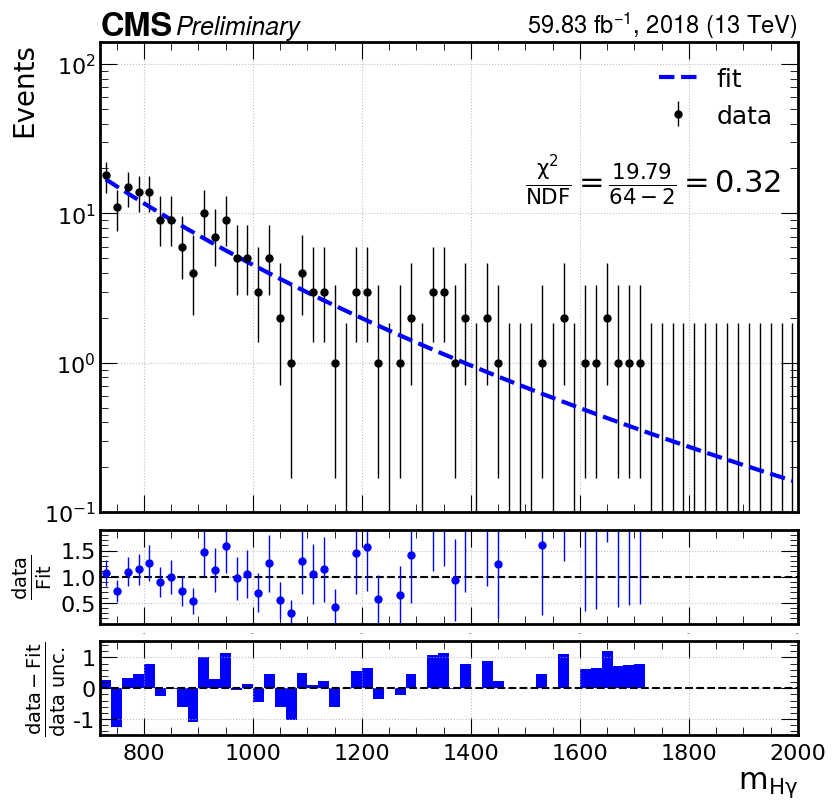

In [345]:
y = '2018'
CR_cut="""(
(
    ((events[y][k].mass_Higgs > 50) & (events[y][k].mass_Higgs < 70)) |
    ((events[y][k].mass_Higgs > 100) & (events[y][k].mass_Higgs < 110)) |
    ((events[y][k].mass_Higgs > 140))
) & (events[y][k].tagger_Hbb > 0.8))"""


with open('output/2018/fit_info_background.yaml', 'r', encoding='utf-8') as f:
    fit_info = yaml.safe_load(f)
arrays={k: events[y][k].mass_Zprime[eval(CR_cut)] for k in events[y] if k == 'data'}
_weight = {k: events[y][k].weight[eval(CR_cut)] for k in arrays}
background_fit(arrays=arrays, weight=_weight, x_name=r'$m_{H\gamma}$', plot_name='sideband_data', bin_width=20, x_min=720, x_max=2000, year='2018', function=dijet2, 
           parameters={k: v for k, v in fit_info.items() if k != 'event_sum'})

/tmp/ipykernel_869968/2551731787.py:55: RuntimeWarning: divide by zero encountered in divide
  hep.histplot(fit_result/h, yerr=fit_result/h/h, bins=hist.axes[0].edges, label=k, histtype='errorbar', stack=False, ax=ax1, color='black')
/home/dfu/anaconda3/lib/python3.11/site-packages/matplotlib/axes/_axes.py:3648: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err
/tmp/ipykernel_869968/2551731787.py:56: RuntimeWarning: divide by zero encountered in divide
  hep.histplot((fit_result-h)/np.mean(err, axis=0), bins=hist.axes[0].edges, label=k, histtype='fill', stack=False, ax=ax2, color='black')


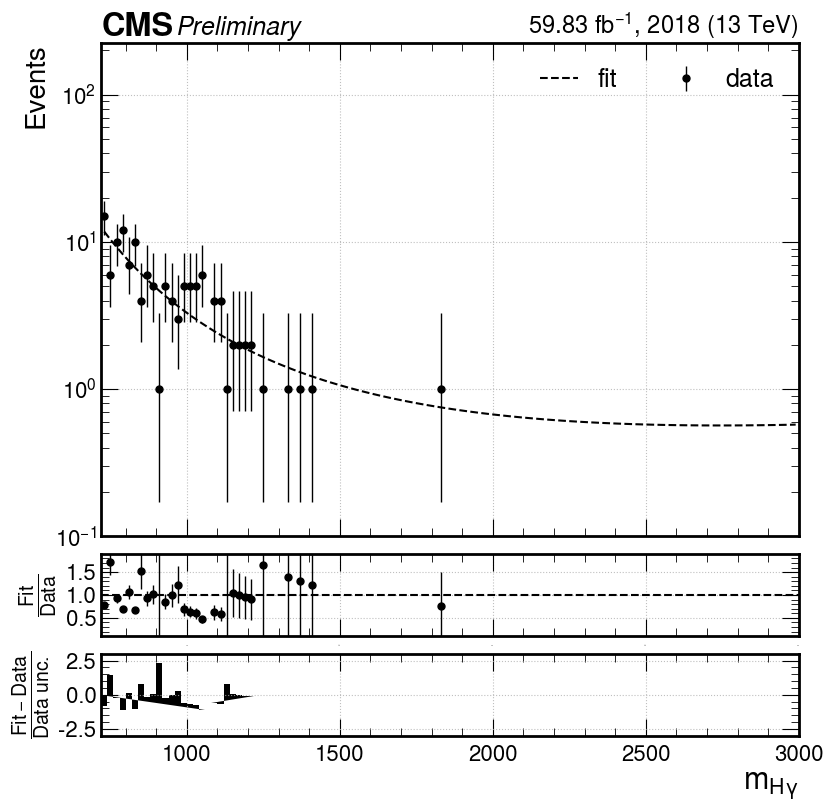

[107.90591751 -27.40474956   1.73087696]


In [52]:
y = '2018'
CR_cut="""(
(
    ((events[y][k].mass_Higgs > 110) & (events[y][k].mass_Higgs < 140))
) & 
(np.abs(events[y][k].photon_eta) < 1.4442) &
(np.abs(events[y][k].AK8jet_eta) < 2.4) & 
(events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) &
(Hbb_tagger[k] > 0.8) & (Hbb_tagger[k] > 0.95)
)"""


arrays={k: events[y][k]['photon+jet_mass'] for k in events[y] if k =='data'}
arrays = {k: v[eval(CR_cut)] for k, v in arrays.items()}
parameters = background_fit(arrays=arrays, weight=None, x_name=r'$m_{H\gamma}$', plot_name='background_in_CR', bin_width=20, x_min=720, x_max=3000, year=y, function=log_dijet, intial_parameters=[np.log(3e3), 400, -2], mode='data')
print(parameters)

/tmp/ipykernel_461266/1385857707.py:47: RuntimeWarning: divide by zero encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_461266/1385857707.py:47: RuntimeWarning: invalid value encountered in multiply
  up_error_bar *= var/h
/tmp/ipykernel_461266/1385857707.py:48: RuntimeWarning: divide by zero encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_461266/1385857707.py:48: RuntimeWarning: invalid value encountered in multiply
  down_error_bar *= var/h
/tmp/ipykernel_461266/3858046143.py:52: RuntimeWarning: Mean of empty slice
  parameters, covariance = curve_fit(function, xdata=x_data[h>1e-1], ydata=np.log(h[h>1e-1]), p0=intial_parameters, sigma=1/np.nan_to_num(np.nanmean(err, axis=0), nan=1))


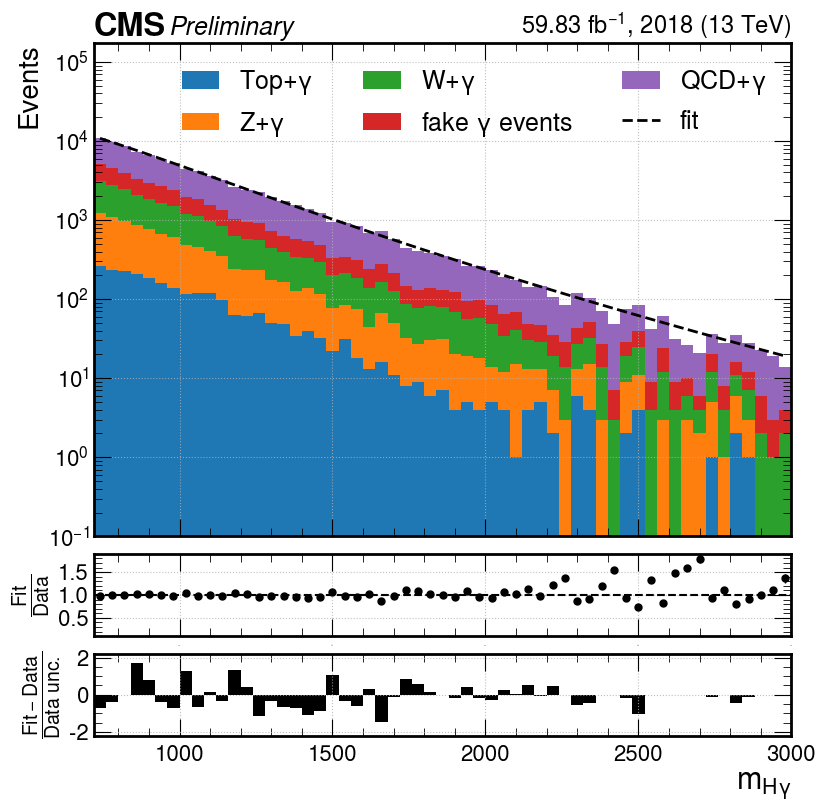

In [78]:
CR_cut="""(
(
    ((events[y][k]['AK8jet_msoftdrop'] > 50) & (events[y][k]['AK8jet_msoftdrop'] < 70)) |
    ((events[y][k]['AK8jet_msoftdrop'] > 100) & (events[y][k]['AK8jet_msoftdrop'] < 110)) |
    ((events[y][k]['AK8jet_msoftdrop'] > 140))
) & 
(np.abs(events[y][k].photon_eta) < 1.4442) &
(np.abs(events[y][k].AK8jet_eta) < 2.4) & 
(events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) &
(Hbb_tagger[k] > 0)
)"""

y = '2018'

arrays={k: events[y][k]['photon+jet_mass'] for k in events[y] if k in BKG}
arrays = {k: v[eval(CR_cut)] for k, v in arrays.items()}
parameters = background_fit(arrays=arrays, weight=None, x_name=r'$m_{H\gamma}$', plot_name='background_in_CR', bin_width=40, x_min=720, x_max=3000, year=y, function=log_dijet, intial_parameters=[np.log(3e3), 400, -2], mode='mc')

In [87]:
def background_fit_closure_test(arrays, weight, plot_name: str, x_name: str, cuts=None, year='2018', bins=None, x_min: float=0, x_max: float=2000, bin_width=None, function=None, intial_parameters=None, mode='data'):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    if mode not in ('data', 'mc'):
        raise ValueError("type argument should be in ('data', 'mc')! ")
    if cuts:
        arrays = {k: v[cuts[k]] for k, v in arrays.items()}
        
    ## canvas initializing
    # f, ax = plt.subplots()
    f = plt.figure(figsize=(9, 9))
    gs = mpl.gridspec.GridSpec(3, 1, height_ratios=[6, 1, 1], hspace=0.08)
    ax, ax1, ax2 = f.add_subplot(gs[0]), f.add_subplot(gs[1]), f.add_subplot(gs[2])
    ax.grid(); ax1.grid(); ax2.grid()
    hep.cms.label(data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')

    ## analyze
    def function_closure_test(x, p0):
        return function(x, p0, *intial_parameters[1:])

    raw = {'h': {}, 'var': {}}

    if bins is None:
        bins = (x_max - x_min)//bin_width
    x_axis = bh.axis.Regular(bins, x_min, x_max)
    hist = bh.Histogram(x_axis, storage=bh.storage.Weight())
    x_data = x_axis.centers
    
    for (k,v) in arrays.items():
        values = ak.fill_none(v, -999)
        
        if k!='data' and weight is not None:
            hist.fill(values, weight=weight[k])
        else:
            hist.fill(values)
        h, var = flow(hist=hist, overflow=False, underflow=False)
        
        raw['h'][k] = h
        raw['var'][k] = var

        
    ## plot
    ax1.plot([x_min,x_max], [1,1], color='black', linestyle='dashed')
    # or you can specify color='blue' in the above function to cover colorlist (you could comment out colorlist too)    
    err = np.sqrt(np.sum([error_bar(h, raw['var'][k], mode=mode)**2 for k, h in raw['h'].items()], axis=0))
    print(err.shape)
    if mode=='data':
        hep.histplot(raw['h'][mode], bins=hist.axes[0].edges, yerr=err, label=mode, histtype='errorbar', stack=False, linewidth=2, ax=ax, color='black')
    else:
        hep.histplot(list(raw['h'].values()), bins=hist.axes[0].edges, label=list(raw['h'].keys()), histtype='fill', stack=True, linewidth=2, ax=ax)
    h = np.sum([raw['h'][k] for k in raw['h']], axis=0)
    parameters, covariance = curve_fit(function_closure_test, xdata=x_data[h>1e-1], ydata=np.log(h[h>1e-1]), p0=intial_parameters[0], sigma=1/np.nan_to_num(np.nanmean(err, axis=0), nan=1)[h>1e-1])
    fit_result = np.exp(function_closure_test(x_data, *parameters))
    ax.plot(x_data, fit_result, label='fit', linestyle='dashed', color='black')
    hep.histplot(fit_result/h, yerr=fit_result/h/h, bins=hist.axes[0].edges, label=k, histtype='errorbar', stack=False, ax=ax1, color='black')
    hep.histplot(np.nan_to_num((fit_result-h)/np.mean(err, axis=0), posinf=0, neginf=0), bins=hist.axes[0].edges, label=k, histtype='fill', stack=False, ax=ax2, color='black')


    ## axises
    ax.set_xlim(x_min, x_max)
    ax.set_yscale('log')
    ax.set_ylim(1e-1, ax.get_ylim()[1]*1e1)
    ax.set_xticklabels([])
    
    # ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    ax.set_ylabel('Events', fontsize=20, ha='right', y=1)
    
    # ratio panel
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(0.1, 1.9)
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax1.tick_params(axis='x', which='major', labelsize=0)
    ax1.set_ylabel(r'$\frac{Fit}{Data}$', fontsize=20, ha='center', y=0.5)
    
    ax2.set_xlim(x_min, x_max)
    ax2.set_ylim(-1.2*max(np.abs(ax2.get_ylim())), +1.2*max(np.abs(ax2.get_ylim())))
    ax2.tick_params(axis='both', which='major', labelsize=16)
    ax2.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax2.set_ylabel(r'$\frac{Fit - Data}{Data\ unc.}$', fontsize=20, ha='center', y=0.5)


    ## title, text and legend
    # plt.title('ROC Curve of HWW4q vs. QCD', fontsize=24,color="black")
    ax.legend(loc="best", ncol=3, frameon=False, fontsize=18)
    #ax.text(0.96*ax.get_xlim()[1], ax.get_ylim()[1]*1e-2, r"$m_H$ in (100, 110) $\cup$ (140, 170)"+"\n& Hbb tagger > 0.95", fontsize=24, color="black", ha='right')

    ## finalizing
    if not os.path.exists('./plots/fit'):
        os.makedirs('./plots/fit')
    plt.savefig(f"./plots/fit/{year}_{plot_name}.pdf", bbox_inches='tight')
    plt.show()
    
    return parameters

/tmp/ipykernel_461266/1385857707.py:31: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_461266/1385857707.py:47: RuntimeWarning: divide by zero encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_461266/1385857707.py:47: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_461266/1385857707.py:47: RuntimeWarning: invalid value encountered in multiply
  up_error_bar *= var/h
/tmp/ipykernel_461266/1385857707.py:48: RuntimeWarning: divide by zero encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_461266/1385857707.py:48: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_461266/1385857707.py:48: RuntimeWarning: invalid value encountered in multiply
  down_error_bar *= var/h
/tmp/ipykernel_461266/1465299282.py:51: RuntimeWarning: Mean of empty slice
  parameters, covariance = curve_fit(function_closure_test, xdata=x_data[h>1e-1], ydata=np.log(h[h>1e-

(2, 57)


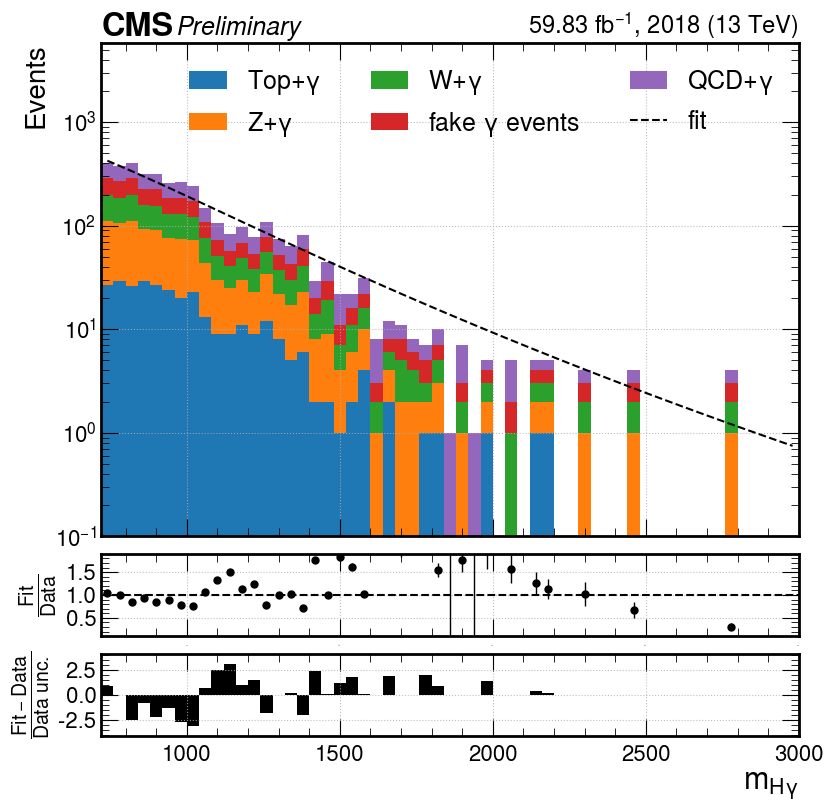

In [88]:
CR_cut = """(
(
    ((events[y][k]['AK8jet_msoftdrop'] > 50) & (events[y][k]['AK8jet_msoftdrop'] < 70)) |
    ((events[y][k]['AK8jet_msoftdrop'] > 100) & (events[y][k]['AK8jet_msoftdrop'] < 110)) |
    ((events[y][k]['AK8jet_msoftdrop'] > 140) & (events[y][k]['AK8jet_msoftdrop'] < 250))
) & 
(np.abs(events[y][k].photon_eta) < 1.4442) &
(np.abs(events[y][k].AK8jet_eta) < 2.4) & 
(events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) &
(Hbb_tagger[k] > 0.95)
)"""

y = '2018'

arrays={k: events[y][k]['photon+jet_mass'] for k in events[y] if k in BKG}
arrays = {k: v[eval(CR_cut)] for k, v in arrays.items()}
parameters_closure_test = background_fit_closure_test(arrays=arrays, weight=None, x_name=r'$m_{H\gamma}$', plot_name='background_in_CR_closure_test', bin_width=40, x_min=720, x_max=3000, year=y, function=log_dijet, intial_parameters=parameters, mode='mc')

/tmp/ipykernel_461266/1385857707.py:31: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_461266/1385857707.py:47: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_461266/1385857707.py:48: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_461266/2874276731.py:62: RuntimeWarning: divide by zero encountered in divide
  hep.histplot(fit_result/h, yerr=fit_result/h/h*err, bins=hist.axes[0].edges, label=k, histtype='errorbar', stack=False, ax=ax1, color='black')


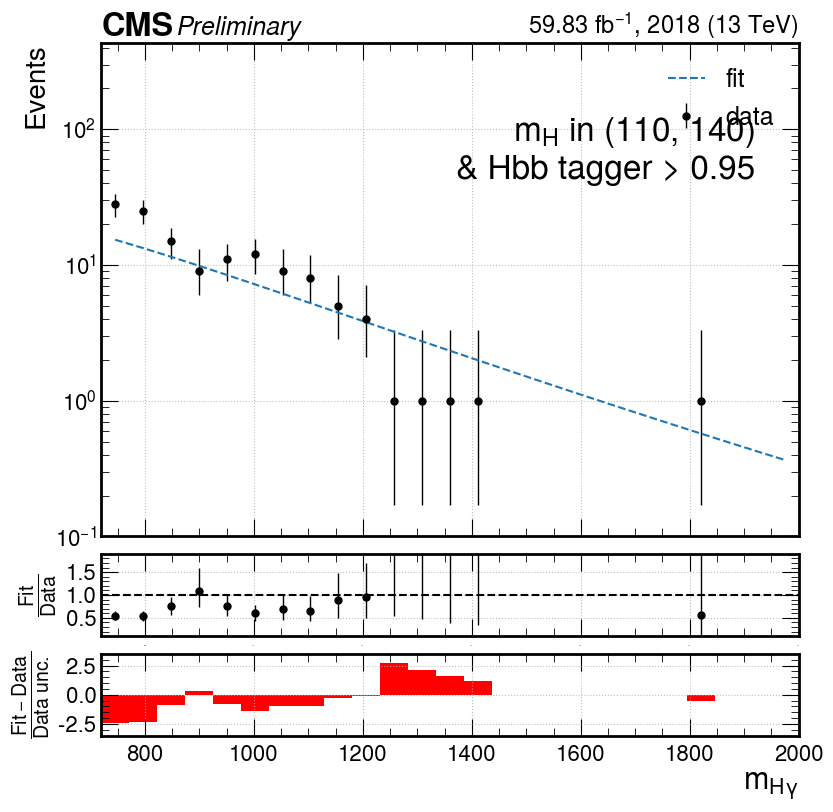

In [32]:
SR_cut="""(
(
    ((events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140)) 
) & 
(np.abs(events[y][k].photon_eta) < 1.4442) &
(np.abs(events[y][k].AK8jet_eta) < 2.4) & 
(events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) &
(Hbb_tagger[k] > 0.95)
)"""

def log_dijet_fixed(x, log_p0):
    p1, p2 = parameters[1:]
    log_x = np.log(x)
    log_y = log_p0 + (p1+p2*log_x)*log_x
    return log_y

def background_fit_SR(arrays, weight, plot_name: str, x_name: str, cuts=None, year='2018', bins=None, x_min: float=0, x_max: float=2000, bin_width=None, function=None, intial_parameters=None, mode='data'):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    if cuts:
        arrays = {k: v[cuts[k]] for k, v in arrays.items()}
        
    ## canvas initializing
    # f, ax = plt.subplots()
    f = plt.figure(figsize=(9, 9))
    gs = mpl.gridspec.GridSpec(3, 1, height_ratios=[6, 1, 1], hspace=0.08)
    ax, ax1, ax2 = f.add_subplot(gs[0]), f.add_subplot(gs[1]), f.add_subplot(gs[2])
    ax.grid(); ax1.grid(); ax2.grid()
    hep.cms.label(data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')
    
    ## analyze
    individual = {'h': {}, 'var': {}}
    
    if bins is None:
        bins = (x_max - x_min)//bin_width
    x_axis = bh.axis.Regular(bins, x_min, x_max)
    hist = bh.Histogram(x_axis, storage=bh.storage.Weight())
    x_data = x_axis.centers
    
    for (k,v) in arrays.items():
        values = ak.fill_none(v, -999)
        
        if k!='data' and weight is not None:
            hist.fill(values, weight=weight[k])
        else:
            hist.fill(values)
        h, var = flow(hist=hist, overflow=False, underflow=False)
        
        if k not in BKG:
            individual['h'][k] = h
            individual['var'][k] = var

        
    ## plot
    ax1.plot([x_min,x_max], [1,1], color='black', linestyle='dashed')
    # or you can specify color='blue' in the above function to cover colorlist (you could comment out colorlist too)
    for (k, h) in individual['h'].items():
        err = error_bar(h, individual['var'][k], mode='mc')
        hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=k, histtype='errorbar', stack=False, linewidth=2, ax=ax, color='black')
        parameters, covariance = curve_fit(function, xdata=x_data[h>0], ydata=np.log(h[h>0]), p0=intial_parameters)
        fit_result = np.exp(function(x_data, *parameters))
        ax.plot(x_data, fit_result, label='fit', linestyle='dashed')
        hep.histplot(fit_result/h, yerr=fit_result/h/h*err, bins=hist.axes[0].edges, label=k, histtype='errorbar', stack=False, ax=ax1, color='black')
        hep.histplot((fit_result-h)/err, bins=hist.axes[0].edges, label=k, histtype='fill', stack=False, ax=ax2, color='red')


    ## axises
    ax.set_xlim(x_min, x_max)
    ax.set_yscale('log')
    ax.set_ylim(1e-1, ax.get_ylim()[1]*1e1)
    ax.set_xticklabels([])
    
    # ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    ax.set_ylabel('Events', fontsize=20, ha='right', y=1)
    
    # ratio panel
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(0.1, 1.9)
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax1.tick_params(axis='x', which='major', labelsize=0)
    ax1.set_ylabel(r'$\frac{Fit}{Data}$', fontsize=20, ha='center', y=0.5)
    
    ax2.set_xlim(x_min, x_max)
    ax2.set_ylim(-1.2*max(np.abs(ax2.get_ylim())), +1.2*max(np.abs(ax2.get_ylim())))
    ax2.tick_params(axis='both', which='major', labelsize=16)
    ax2.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax2.set_ylabel(r'$\frac{Fit - Data}{Data\ unc.}$', fontsize=20, ha='center', y=0.5)


    ## title, text and legend
    # plt.title('ROC Curve of HWW4q vs. QCD', fontsize=24,color="black")
    ax.legend(loc="best", ncol=1, frameon=False, fontsize=18)
    ax.text(0.96*ax.get_xlim()[1], ax.get_ylim()[1]*1e-1, r"$m_H$ in (110, 140)"+"\n& Hbb tagger > 0.95", fontsize=24, color="black", ha='right')

    ## finalizing
    if not os.path.exists('./plots/fit'):
        os.makedirs('./plots/fit')
    plt.savefig(f"./plots/fit/{year}_{plot_name}.pdf", bbox_inches='tight')
    plt.show()
    
    return parameters


y = '2018'

arrays={k: events[y][k]['photon+jet_mass'] for k in events[y] if k == 'data'}
arrays = {k: v[eval(SR_cut)] for k, v in arrays.items()}
SR_parameters = background_fit_SR(arrays=arrays, weight=None, x_name=r'$m_{H\gamma}$', plot_name='background_in_CR', bin_width=50, x_min=720, x_max=2000, year=y, function=log_dijet_fixed, intial_parameters=[np.log(3e3)])

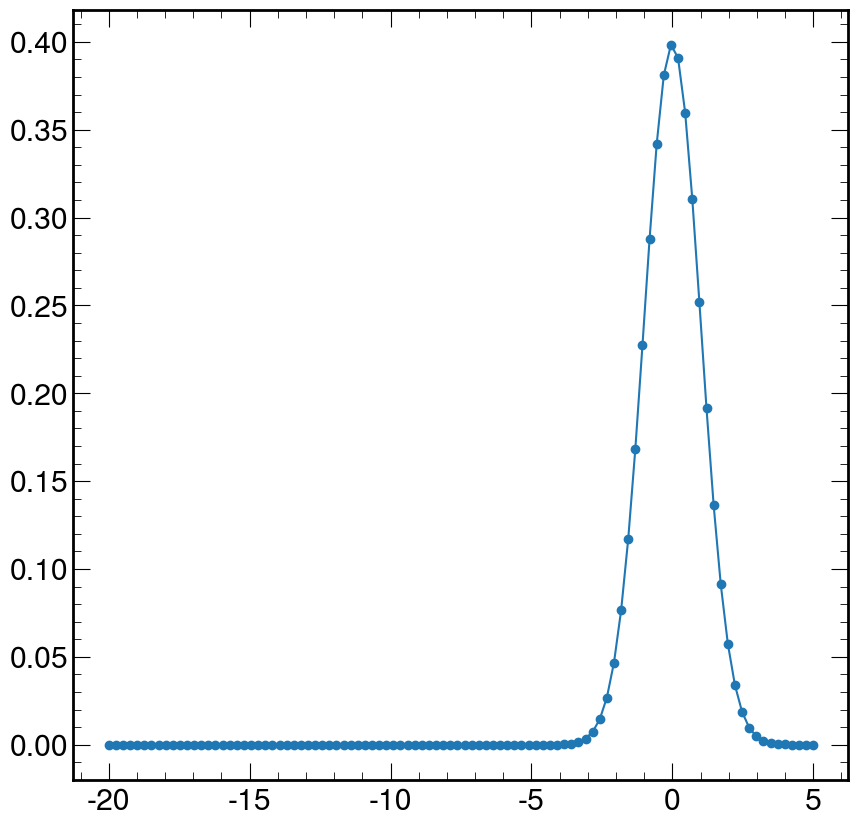

In [ ]:
x = np.linspace(start=-20, stop=5, num=100)
parameters = {'beta': 10, 'xbar': 0, 'sigma': 1, 'N': 1, 'm': 5}

fit_result = np.array([crystallBall(x=i, **parameters) for i in x])

plt.plot(x, fit_result, '-o', label='fit')

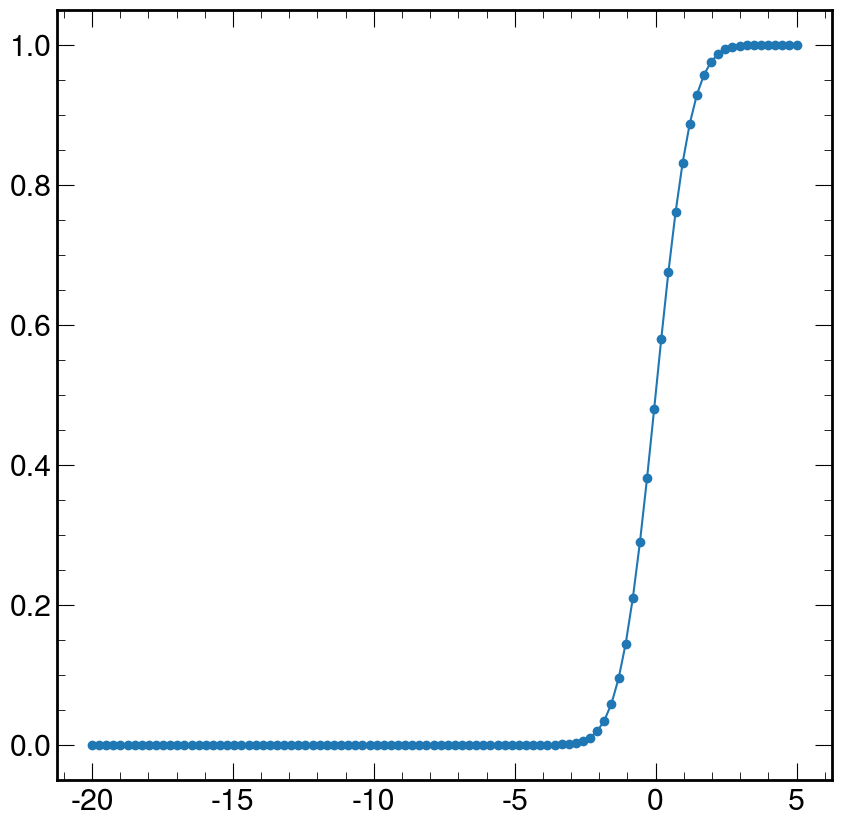

In [ ]:
cdf = sps.crystalball.cdf(x=x, beta=10, m=5, loc=0, scale=1)
plt.plot(x, cdf, '-o', label='fit')

In [ ]:
sps.kstest(stats.uniform.rvs(size=100, random_state=rng), cdf)

KstestResult(statistic=0.72, pvalue=2.6766397956445386e-25, statistic_location=0.03451817399720775, statistic_sign=-1)